# Art classification using deep learning

The project aims to classify two styles of art: western (Rococo), and Japanese using convolutional neural networks.

## CNN Implementation

### 1. Reading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import ImageDataGenerator

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=5,
    zoom_range=0.05,
    horizontal_flip=True,
    validation_split=0.1
)

train_ds = datagen.flow_from_directory(
    directory='train_test/train',
    target_size=(256, 256),  
    class_mode='categorical', 
    batch_size=32,
    seed=1992,
    shuffle=True
)

valid_ds = datagen.flow_from_directory(
    directory='train_test/valid',
    target_size=(256, 256), 
    class_mode='categorical', 
    batch_size=32,
    seed=1992,
    shuffle=True
)

test_ds = datagen.flow_from_directory(
    directory='train_test/test',
    target_size=(256, 256), 
    class_mode='categorical',
    batch_size=32,
    seed=1992,
    shuffle=True
)

Found 3279 images belonging to 2 classes.
Found 984 images belonging to 2 classes.
Found 423 images belonging to 2 classes.


### 2. Model implementation

In [4]:
xy = 256

In [5]:
#https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/
model_cnn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(xy, xy, 3)),
    tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(xy, xy, 3)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 1), activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 1), activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [6]:
# stops the training if the model stops improving for 5 epochs
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    patience = 10, 
    restore_best_weights = True, 
    verbose = 1,
    monitor='val_loss')


# setting up learning rate for faster convergance
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# setting the opitmizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_cnn.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'] 
)

# fitting the model
history_cnn = model_cnn.fit(train_ds, 
                                 epochs=50,
                                 validation_data=valid_ds,
                                 callbacks = [early_stopping_callbacks])

Epoch 1/50
103/103 [==============================] - 165s 2s/step - loss: 2.0131 - accuracy: 0.8143 - val_loss: 1.7443 - val_accuracy: 0.5285
Epoch 2/50
103/103 [==============================] - 118s 1s/step - loss: 0.4633 - accuracy: 0.8640 - val_loss: 0.9837 - val_accuracy: 0.5285
Epoch 3/50
103/103 [==============================] - 117s 1s/step - loss: 0.3534 - accuracy: 0.8820 - val_loss: 0.5309 - val_accuracy: 0.6758
Epoch 4/50
103/103 [==============================] - 114s 1s/step - loss: 0.3497 - accuracy: 0.8808 - val_loss: 3.6469 - val_accuracy: 0.5325
Epoch 5/50
103/103 [==============================] - 112s 1s/step - loss: 0.3099 - accuracy: 0.8872 - val_loss: 0.4314 - val_accuracy: 0.7632
Epoch 6/50
103/103 [==============================] - 111s 1s/step - loss: 0.2682 - accuracy: 0.8957 - val_loss: 0.3449 - val_accuracy: 0.8445
Epoch 7/50
103/103 [==============================] - 112s 1s/step - loss: 0.2536 - accuracy: 0.9097 - val_loss: 0.2770 - val_accuracy: 0.8882

In [11]:
# saving the model
import pickle

# Pickle the model
with open("model_cnn.pkl", "wb") as file:
    pickle.dump(model_cnn, file)

INFO:tensorflow:Assets written to: ram://6336f080-af75-48d4-9402-ad794db54d7a/assets


INFO:tensorflow:Assets written to: ram://6336f080-af75-48d4-9402-ad794db54d7a/assets


In [30]:
# model_cnn.save('model_cnn.keras')

In [25]:
model_cnn = tf.keras.models.load_model('trained_models/model_cnn.keras')

### 3. Evaluation

In [26]:
predictions = model_cnn.predict(test_ds)

14/14 [==============================] - 10s 741ms/step


In [28]:
predictions[2]

array([0.00172697, 0.998273  ], dtype=float32)

In [12]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_acc_cnn)

14/14 - 10s - loss: 0.3014 - accuracy: 0.8794 - 10s/epoch - 746ms/step

Test accuracy: 0.8794326186180115


#### varify prediction

In [13]:
test_img = predictions[0]
test_img

array([0.14735468, 0.85264534], dtype=float32)

In [17]:
test_ds.class_indices

{'Japanese_Art': 0, 'Rococo': 1}

(256, 256, 3)
[0. 1.]


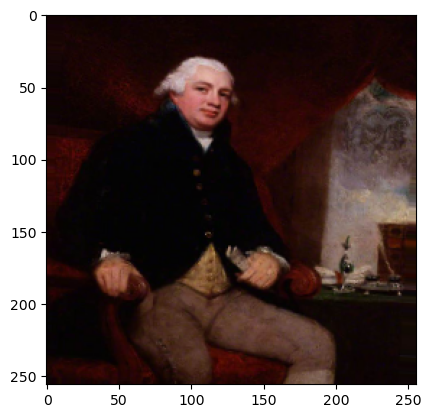

In [6]:
# Get the next batch
images, labels = next(train_ds)

# Retrieve the first image from the batch
first_image = images[1]

# Print information about the first image and label
print(first_image.shape)
print(labels[0])

# Display the first image
plt.imshow(first_image)
plt.show()

In [76]:
# now let's see the prediction
img_array = np.expand_dims(first_image, axis=0)
model_cnn.predict(img_array)

1/1 [==============================] - 0s 17ms/step


array([[0.6779843 , 0.32201573]], dtype=float32)

#### accuracy and loss graphs

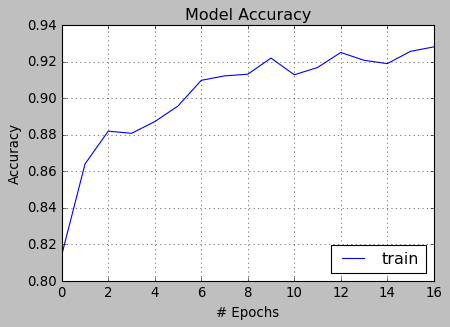

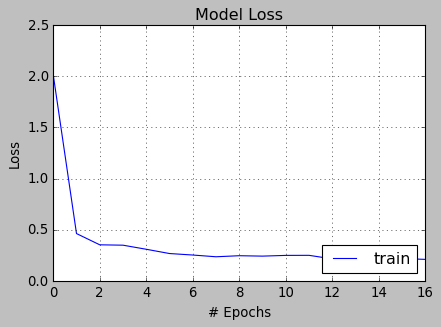

In [14]:
epoch = len(history_cnn.history.get('loss',[]))

# Draw Model Accuracy
plt.figure(2,figsize=(6,4))
plt.plot(range(epoch),history_cnn.history.get('accuracy'))
#plt.plot(range(epoch),training_history.history.get('val_acc'))
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(['train','validation'],loc=4)
plt.style.use(['classic'])

# Draw Model Loss
plt.figure(1,figsize=(6,4))
plt.plot(range(epoch),history_cnn.history.get('loss'))
#plt.plot(range(epoch),training_history.history.get('val_loss'))
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(['train','validation'], loc=4)
plt.style.use(['classic'])

#### Preprocessing and prediction tests for the Flask App

In [62]:
from keras_preprocessing.image import load_img, img_to_array

image = load_img('./train_test/test/Rococo/235430.jpg', target_size=(256,256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = datagen.standardize(image)

In [98]:
test_prediction = model_cnn.predict(image)
print(max(test_prediction[0]))

1/1 [==============================] - 0s 19ms/step


0.97518224


In [89]:
classes = list(test_ds.class_indices.keys())
predicted_class = classes[np.argmax(test_prediction)]
print(predicted_class)

Rococo


In [99]:
model_cnn.save('trained_models/model.h5')

### 4. Summary

I employed Keras to read the data in batches, utilizing a batching approach for file ingestion. To augment the dataset and enhance the sample size input into the model, I implemented data augmentation techniques. My efforts involved a strategic combination of various convolutional, normalization, and regularization layers, resulting in the highest observed accuracy.

I plan on expanding this project to include more styles from the dataset and work on analyzing where the system fail to classify.